First Assignment Research Track 2
=====

The assignment is developed by the student Francesco Ferrazzi 5262829, course of Robotics Engineering, provided by [Università degli Studi di Genova](https://unige.it/it/).

The assignment consists in:

* properly comment the the third assignment of the Research Track 1 course using sphinx (done in a different script).
* create a jupyter notebook to interract with the simulation of the third assignment of the Research Track 1 course, which is able to:
    * switch to different modalities, and manage them.
    * plot the robot position, the laser scanner data and reached/non-reached targets
* perform a statistical analysis on the first assignment, considering my implementation and a given solution found in the [CarmineD8](https://github.com/CarmineD8/python_simulator/tree/rt2) and testing which one performs better in the given circuit, when silver tokens are randomly placed in the environment.


# Jupyer Notebook

The following project is about the second point of the list which was previously described.

The aim is to replace the old user interface developed for the course Research Track 1 using functions and widgets to give a better developed and more user friendly interface.

Some new functionalities that the code must guarantee are:
* plot the robot position and laser scan 
* plot the number of reached and unreached targets
* use buttons for handling the different modalities

## How to run

To run the program is essential to clone the whole directory and run the ROS simulation before launching the Jupyter notebook.

To launch the simulation, it is sufficent to type the following command in the terminal:
```
$ roslaunch rt2_first_assignment rt2_first_assignment.launch
```
Once launched, be careful to control that the move_base package is running correctly, since it could happen that it won't work sometimes.
If this happens, stop the simulation and launch it again.

It is now time to launch the Jupyter notebook.
To run it i recommend using the 'Restart & Run All' command placed in the 'Kernel' menu since the notebook's cells should be run in order.

## Import

Let's start the notebook by import all the libraries and define all the messages which are going to be needed in the project

In [1]:
# Libraries
import rospy
import time
import os
import tf
import sys
import actionlib
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
import jupyros as jr

%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

# Messages
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
from matplotlib.animation import FuncAnimation
from matplotlib import pyplot as plt
from jupyros import ros3d
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
from std_msgs.msg import Float32, Int32

# Custom services
from rt2_first_assignment.srv import Command
from rt2_first_assignment.srv import Target
# Custom message
from rt2_first_assignment.msg import GoalStatus

## Initialize ROS node

The rospy.init_node function initializes the ROS node, and right after that a publisher for the cmd_vel topic is declared

In [2]:
rospy.init_node('jupyter_node')
# Service used to communicate with the ROS node and sends to it the command for the wanted behavior 
client_comm = rospy.ServiceProxy("/command", Command)
# Service used to communicate with the ROS node and sends to it the target position
client_targ = rospy.ServiceProxy("/target", Target)
# Velocity publisher
vel_pub = jr.publish('cmd_vel', Twist)

## User Interface

In this part I display the widgets that are going to be used by the user to decide the driving modalities, in particular there are:
1. buttons to change modalities
2. buttons to control the robot while the manual mode is active
3. cells to acquire the target position 

In [3]:
# 1) This widget displays the driving modalities and other useful buttons
b1 = Button(description = 'Autonomus Drive',
           layout = Layout(width = 'auto', align = "center", grid_area = 'b1'),
           style = ButtonStyle(button_color = 'lightblue'))

b2 = Button(description = 'Manual NO Assistance',
           layout = Layout(width = 'auto', grid_area = 'b2'),
           style = ButtonStyle(button_color = 'lightblue'))

b3 = Button(description = 'Manual Assistance',
           layout = Layout(width = 'auto', grid_area = 'b3'),
           style = ButtonStyle(button_color = 'lightblue'))

b4 = Button(description = 'Cancel Goal',
           layout = Layout(width = 'auto', grid_area = 'b4'),
           style = ButtonStyle(button_color = 'lightblue'))

b5 = Button(description = 'Reset Position',
           layout = Layout(width = 'auto', grid_area = 'b5'),
           style = ButtonStyle(button_color = 'lightblue'))

b6 = Button(description = 'Kill Program',
           layout = Layout(width = 'auto', grid_area = 'b6'),
           style = ButtonStyle(button_color = 'moccasin'))

b7 = Button(description = 'Send Goal',
           layout = Layout(width = 'auto', grid_area = 'b7'),
           style = ButtonStyle(button_color = 'lightblue'))


# 2) This widget displays the buttons to control the robot in manual mode
b8 = Button(description = 'Left turn',
           layout = Layout(width = 'auto', grid_area = 'b8'),
           style = ButtonStyle(button_color = 'lightblue'))

b9 = Button(description = 'Straight',
           layout = Layout(width = 'auto', grid_area = 'b9'),
           style = ButtonStyle(button_color = 'lightblue'))

b10 = Button(description = 'Right turn',
           layout = Layout(width = 'auto', grid_area = 'b10'),
           style = ButtonStyle(button_color = 'lightblue'))

b11 = Button(description = 'Left in pos',
           layout = Layout(width = 'auto', grid_area = 'b11'),
           style = ButtonStyle(button_color = 'lightblue'))

b12 = Button(description = 'Back',
           layout = Layout(width = 'auto', grid_area = 'b12'),
           style = ButtonStyle(button_color = 'lightblue'))

b13 = Button(description = 'Right in pos',
           layout = Layout(width = 'auto', grid_area = 'b13'),
           style = ButtonStyle(button_color = 'lightblue'))

b14 = Button(description = 'STOP',
           layout = Layout(width = 'auto', grid_area = 'b14'),
           style = ButtonStyle(button_color = 'moccasin'))


# 3) This widget is used to acquire a floating target position from user
x_target = widgets.FloatText(
    value = 0,
    description = 'X goal:',
    disabled = False,
)

y_target = widgets.FloatText(
    value = 0,
    description = 'Y goal:',
    disabled = False,
)

## Robot Behavior

In this part of the notebook the robot assumes the correct behavior according to the user choice. It is decided by clicking on the buttons displayed in the **user interface**.

At the beginning the user can choose between the driving modalities.

After that, other user interfaces are displayed according to the choice.

In [4]:
# Define vel msg
vel_msg = Twist()
# Define the velocity that will be published
vel = 0.8
# Publisher for the velocity in second and third modality 
us_vel_pub = rospy.Publisher('/us_cmd_vel', Twist, queue_size = 100)
# Global variable to set the correct behavior in the code
global command, pos_x, pos_y, vel_msg, vel
    
# Display the user intefrace to set a new goal
def autonomus_drive(b):
    rospy.wait_for_service("/command")
    # Set autonomus mode on
    command = 1
    res1 = client_comm(command)

# Set the robot to manual mode without assistance
def manual_drive_no_assistance(b):
    rospy.wait_for_service("/command")
    print("Manual Drive with NO Assistance")
    # Set manual mode on (No assistance)
    command = 2
    res1 = client_comm(command)
     
# Set the robot to manual mode with assistance
def manual_drive_assistance(b):
    rospy.wait_for_service("/command")
    print("Manual Drive with Assistance")
    # Set manual mode on (Assistance)
    command = 3
    res1 = client_comm(command)
    
# Cancel the goal if one has been set
def cancel_goal(b):
    rospy.wait_for_service("/command")
    print("Goal has been canceled")
    # Cancel the goal
    command = 4
    res1 = client_comm(command)
    
# Reset the position of the robot in the environment
def reset_position(b):
    rospy.wait_for_service("/command")
    print("Robot's position has been resetted")
    # Reset position
    command = 9
    res1 = client_comm(command)
    
# Exits the program and cloeses all windows
def kill_program(b):
    rospy.wait_for_service("/command")
    print("Program KILLED")
    # Quit program
    command = 0
    res1 = client_comm(command)
    
# Set the target position that the robot will autonomusly reach
def set_position(b):
    rospy.wait_for_service("/target")
    global x_target, y_target
    pos_x = x_target.value
    pos_y = y_target.value
    res2 = client_targ(pos_x, pos_y)
    print("Target position has been sent")
    
# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def go_straight(b):
    vel_msg.linear.x = vel
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = 0
    us_vel_pub.publish(vel_msg)
    
# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def turn_left(b):
    vel_msg.linear.x = vel
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = vel
    us_vel_pub.publish(vel_msg)

# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def turn_right(b):
    vel_msg.linear.x = vel
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = -vel
    us_vel_pub.publish(vel_msg)
    
# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def left_in_position(b):
    vel_msg.linear.x = 0
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = vel
    us_vel_pub.publish(vel_msg)
    
# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def go_back(b):
    vel_msg.linear.x = -vel
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = 0
    us_vel_pub.publish(vel_msg)
    
# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def right_in_position(b):
    vel_msg.linear.x = 0
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = -vel
    us_vel_pub.publish(vel_msg)
    
# Publishes the velocity in the /us_cmd_vel topic and will be checked by collision avoidence if required or published if not
def stop_move(b):
    vel_msg.linear.x = 0
    vel_msg.linear.y = 0
    vel_msg.linear.z = 0
    vel_msg.angular.x = 0
    vel_msg.angular.y = 0
    vel_msg.angular.z = 0
    us_vel_pub.publish(vel_msg)
    
# Call functions when a button is clicked
b1.on_click(autonomus_drive)
b2.on_click(manual_drive_no_assistance)
b3.on_click(manual_drive_assistance)
b4.on_click(cancel_goal)
b5.on_click(reset_position)
b6.on_click(kill_program)
b7.on_click(set_position)
b8.on_click(turn_left)
b9.on_click(go_straight)
b10.on_click(turn_right)
b11.on_click(left_in_position)
b12.on_click(go_back)
b13.on_click(right_in_position)
b14.on_click(stop_move)

## Display UI

In [5]:
print('Choose one of the following modalities: ')

GridBox(children = [b1, b2, b3, b4, b5, b6],
       layout = Layout(
           width = '100%',
           grid_template_rows = 'auto auto auto',
           grid_template_columns = '50% 50%',
           grid_template_areas = '''
           "b1 b4"
           "b2 b3"
           "b5 b6"
           ''')
        )

Choose one of the following modalities: 


GridBox(children=(Button(description='Autonomus Drive', layout=Layout(grid_area='b1', width='auto'), style=But…

Goal has been canceled
Robot's position has been resetted
Manual Drive with NO Assistance
Manual Drive with Assistance


In [6]:
print('Select (x,y) goal position after selecting AUTONOMUS DRIVE: ')
print('Press button Send Goal once the goal is set! ')

GridBox(children = [x_target, y_target, b7],
       layout = Layout(
           width = '100%',
           grid_template_rows = 'auto auto',
           grid_template_columns = '50% 50%',
           grid_template_areas = '''
           "x_target y_target"
           "b7 b7"
           ''')
        )

Select (x,y) goal position after selecting AUTONOMUS DRIVE: 
Press button Send Goal once the goal is set! 


GridBox(children=(FloatText(value=0.0, description='X goal:'), FloatText(value=0.0, description='Y goal:'), Bu…

Target position has been sent
Target position has been sent


In [7]:
print('Use the interface after selecting MANUAL NO ASSISTANCE or MANUAL ASSISTANCE')
print('Please, control the robot using the following buttons: ')

GridBox(children = [b8, b9, b10, b11, b12, b13, b14],
       layout = Layout(
           width = '100%',
           grid_template_rows = 'auto auto auto',
           grid_template_columns = '33% 33% 33%',
           grid_template_areas = '''
           "b8 b9 b10"
           "b11 b12 b13"
           "b14 b14 b14"
           ''')
        )

Use the interface after selecting MANUAL NO ASSISTANCE or MANUAL ASSISTANCE
Please, control the robot using the following buttons: 


GridBox(children=(Button(description='Left turn', layout=Layout(grid_area='b8', width='auto'), style=ButtonSty…

## Data visualization

This cell is about the visualisation of the robot's odometry, the laser scan data and the reached and unreached targets.

<IPython.core.display.Javascript object>


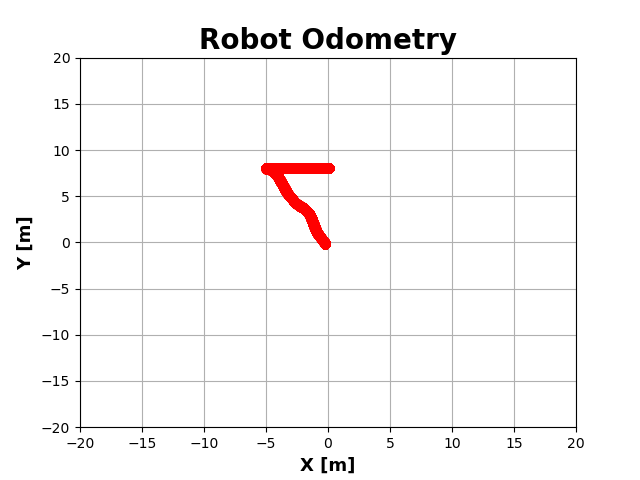

<IPython.core.display.Javascript object>


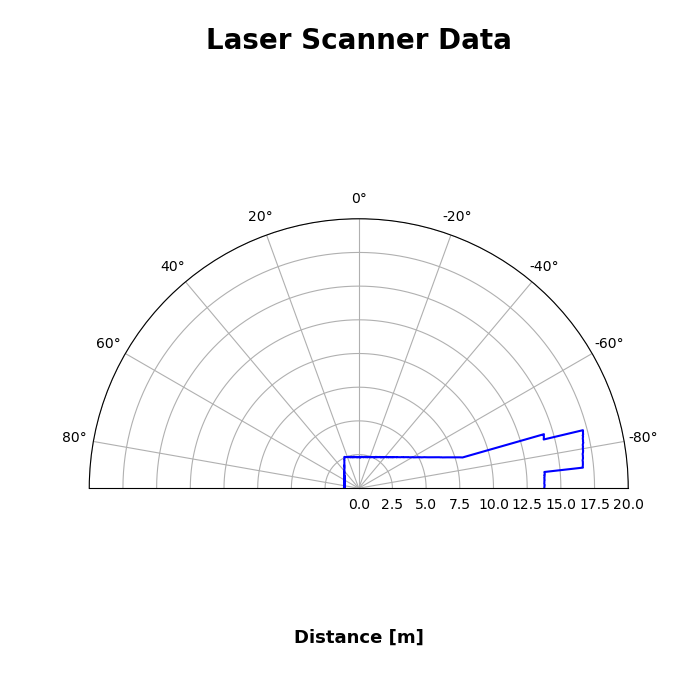

<IPython.core.display.Javascript object>


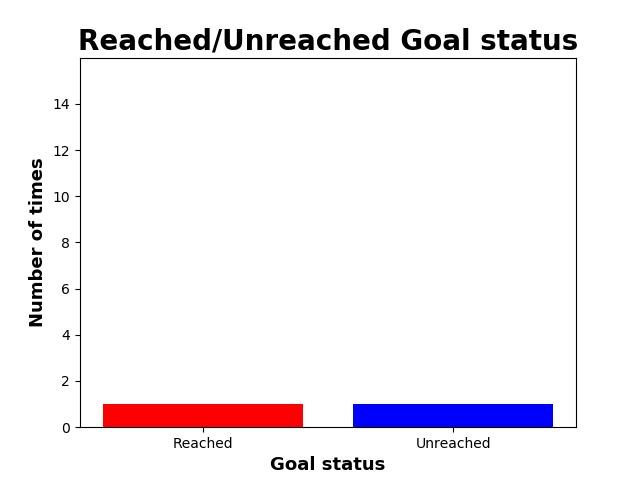

In [8]:
laser_ang = [] # for laser scan

# This class is done for visualise the data i want to see
class Visualiser:
    
    # Creates the plot
    def __init__(self):
        # Creates subplot for Odometry 
        self.fig_odom, self.ax1 = plt.subplots()
        plt.grid(True)
        self.ln1, = self.ax1.plot([], [], 'ro')
        self.x_data, self.y_data = [], []
        # Creates subplot for Laser Scanner
        self.fig_laser = plt.figure(figsize = (7, 7))
        self.ax2 = plt.subplot(111, polar = True)
        plt.grid(True)
        self.ax2.set_thetalim(-np.pi/2, np.pi/2)
        self.ax2.set_rmax(20)
        self.ax2.set_theta_zero_location("N")
        self.ln2, = self.ax2.plot([], [], 'b-')
        self.laser_dist = []
        # Creates subplot for Reached/Unreached targets
        self.fig_goal, self.ax3 = plt.subplots()
        plt.grid(False)
        self.reached = 0
        self.unreached = 0
        self.ln3 = plt.bar(['Reached', 'Unreached'], [self.reached, self.unreached], color = ['red', 'blue'])

    # Initializes the plots
    def plot_init(self):
        # Initializes the odometry plot
        self.ax1.set_title("Robot Odometry", fontsize = 20, fontweight = 'bold')
        self.ax1.set_xlabel("X [m]", fontsize = 13, fontweight = "bold")
        self.ax1.set_ylabel("Y [m]", fontsize = 13, fontweight = "bold")
        self.ax1.set_xlim(-20, 20)
        self.ax1.set_ylim(-20, 20)
        # Initializes laser scan data plot
        self.ax2.set_title("Laser Scanner Data", fontsize = 20, fontweight = "bold")
        self.ax2.set_xlabel("Distance [m]", fontsize = 13, fontweight = "bold")
        # Initializes the reached/unreached plots
        self.ax3.set_title("Reached/Unreached Goal status", fontsize = 20, fontweight = "bold")
        self.ax3.set_xlabel("Goal status", fontsize = 13, fontweight = "bold")
        self.ax3.set_ylabel("Number of times", fontsize = 13, fontweight = "bold")
        self.ax3.set_ylim(0, 16)
        self.ax3.set_yticks(np.arange(0, 16, 2))
        # Return what i got
        return self.ln1, self.ln2, self.ln3
    
    # Subscriber for the robot's odometry
    def odom_callback(self, msg):
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
     
    # Subscriber for the robot's laser scan
    def laser_callback(self, msg):
        global laser_ang
        self.laser_dist = msg.ranges
        laser_ang = np.arange(msg.angle_min, msg.angle_max+msg.angle_increment, msg.angle_increment)
        
    # Subscriber for the goal status
    def status_callback(self, msg):
        self.reached = msg.reach
        self.unreached = msg.unreach
        
    # This function is used to update the robot's odometry plot
    def update_plot_odom(self, frame):
        self.ln1.set_data(self.x_data, self.y_data)
        return self.ln1
        
    # This function is used to update the robot's laser data plot
    def update_plot_laser(self, frame):
        global laser_ang
        self.ax2.set_rmax(20)
        self.ln2.set_data(laser_ang, self.laser_dist)
        return self.ln2
    
     # This function is used to update the Reached/Unreached plot
    def update_plot_goal(self, frame):
        self.ln3 = plt.bar(['Reached', 'Unreached'], [self.reached, self.unreached], color = ['red', 'blue'])
        return self.ln3

# Class
vis = Visualiser()

# Subscribers
sub_odom = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
sub_laser = rospy.Subscriber('/scan', LaserScan, vis.laser_callback)
sub_status = rospy.Subscriber('/status_goal', GoalStatus, vis.status_callback)

# Update the plot
ani_odom = FuncAnimation(vis.fig_odom, vis.update_plot_odom, init_func = vis.plot_init) 
ani_laser = FuncAnimation(vis.fig_laser, vis.update_plot_laser, init_func = vis.plot_init)
ani_goal = FuncAnimation(vis.fig_goal, vis.update_plot_goal, init_func = vis.plot_init)

# Show plot
plt.show(block = True)